In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Sepulveda2020_perceptual_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7555, 5) (7555, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 1s 570ms/step - loss: 73448.5938
Epoch 2/3000
1/1 [==============================] - 0s 3ms/step - loss: 72888.2500
Epoch 3/3000
1/1 [==============================] - 0s 3ms/step - loss: 72489.9219
Epoch 4/3000
1/1 [==============================] - 0s 4ms/step - loss: 72159.7188
Epoch 5/3000
1/1 [==============================] - 0s 5ms/step - loss: 71867.7500
Epoch 6/3000
1/1 [==============================] - 0s 4ms/step - loss: 71600.1719
Epoch 7/3000
1/1 [==============================] - 0s 5ms/step - loss: 71351.9062
Epoch 8/3000
1/1 [==============================] - 0s 4ms/step - loss: 71122.6250
Epoch 9/3000
1/1 [==============================] - 0s 4ms/step - loss: 70909.1484
Epoch 10/3000
1/1 [==============================] - 0s 3ms/step - loss: 70708.4688
Epoch 11/3000
1/1 [==============================] - 0s 3ms/step - loss: 70518.3672
Epoch 12/3000
1/1 [==============================] - 0s 4ms/step - loss: 70336.8203

1/1 [==============================] - 0s 4ms/step - loss: 59428.7422
Epoch 99/3000
1/1 [==============================] - 0s 4ms/step - loss: 59354.3203
Epoch 100/3000
1/1 [==============================] - 0s 4ms/step - loss: 59280.7109
Epoch 101/3000
1/1 [==============================] - 0s 4ms/step - loss: 59207.8711
Epoch 102/3000
1/1 [==============================] - 0s 5ms/step - loss: 59135.7812
Epoch 103/3000
1/1 [==============================] - 0s 4ms/step - loss: 59064.4844
Epoch 104/3000
1/1 [==============================] - 0s 4ms/step - loss: 58993.9766
Epoch 105/3000
1/1 [==============================] - 0s 4ms/step - loss: 58924.2500
Epoch 106/3000
1/1 [==============================] - 0s 4ms/step - loss: 58855.2812
Epoch 107/3000
1/1 [==============================] - 0s 4ms/step - loss: 58787.0469
Epoch 108/3000
1/1 [==============================] - 0s 4ms/step - loss: 58719.5352
Epoch 109/3000
1/1 [==============================] - 0s 4ms/step - loss: 58652.7

1/1 [==============================] - 0s 4ms/step - loss: 54642.8281
Epoch 195/3000
1/1 [==============================] - 0s 4ms/step - loss: 54608.4141
Epoch 196/3000
1/1 [==============================] - 0s 5ms/step - loss: 54574.2031
Epoch 197/3000
1/1 [==============================] - 0s 4ms/step - loss: 54540.1719
Epoch 198/3000
1/1 [==============================] - 0s 4ms/step - loss: 54506.3281
Epoch 199/3000
1/1 [==============================] - 0s 4ms/step - loss: 54472.6680
Epoch 200/3000
1/1 [==============================] - 0s 4ms/step - loss: 54439.1836
Epoch 201/3000
1/1 [==============================] - 0s 4ms/step - loss: 54405.8828
Epoch 202/3000
1/1 [==============================] - 0s 4ms/step - loss: 54372.7578
Epoch 203/3000
1/1 [==============================] - 0s 5ms/step - loss: 54339.8086
Epoch 204/3000
1/1 [==============================] - 0s 4ms/step - loss: 54307.0352
Epoch 205/3000
1/1 [==============================] - 0s 4ms/step - loss: 54274.

1/1 [==============================] - 0s 4ms/step - loss: 51956.0469
Epoch 291/3000
1/1 [==============================] - 0s 4ms/step - loss: 51932.6406
Epoch 292/3000
1/1 [==============================] - 0s 4ms/step - loss: 51909.2969
Epoch 293/3000
1/1 [==============================] - 0s 4ms/step - loss: 51886.0156
Epoch 294/3000
1/1 [==============================] - 0s 5ms/step - loss: 51862.8008
Epoch 295/3000
1/1 [==============================] - 0s 4ms/step - loss: 51839.6445
Epoch 296/3000
1/1 [==============================] - 0s 4ms/step - loss: 51816.5625
Epoch 297/3000
1/1 [==============================] - 0s 5ms/step - loss: 51793.5273
Epoch 298/3000
1/1 [==============================] - 0s 4ms/step - loss: 51770.5664
Epoch 299/3000
1/1 [==============================] - 0s 4ms/step - loss: 51747.6602
Epoch 300/3000
1/1 [==============================] - 0s 4ms/step - loss: 51724.8086
Epoch 301/3000
1/1 [==============================] - 0s 5ms/step - loss: 51702.

1/1 [==============================] - 0s 4ms/step - loss: 49938.0430
Epoch 387/3000
1/1 [==============================] - 0s 5ms/step - loss: 49918.9141
Epoch 388/3000
1/1 [==============================] - 0s 4ms/step - loss: 49899.8203
Epoch 389/3000
1/1 [==============================] - 0s 4ms/step - loss: 49880.7539
Epoch 390/3000
1/1 [==============================] - 0s 4ms/step - loss: 49861.7266
Epoch 391/3000
1/1 [==============================] - 0s 5ms/step - loss: 49842.7227
Epoch 392/3000
1/1 [==============================] - 0s 4ms/step - loss: 49823.7500
Epoch 393/3000
1/1 [==============================] - 0s 4ms/step - loss: 49804.8086
Epoch 394/3000
1/1 [==============================] - 0s 5ms/step - loss: 49785.8984
Epoch 395/3000
1/1 [==============================] - 0s 4ms/step - loss: 49767.0117
Epoch 396/3000
1/1 [==============================] - 0s 4ms/step - loss: 49748.1562
Epoch 397/3000
1/1 [==============================] - 0s 4ms/step - loss: 49729.

1/1 [==============================] - 0s 4ms/step - loss: 48223.0156
Epoch 483/3000
1/1 [==============================] - 0s 5ms/step - loss: 48206.2812
Epoch 484/3000
1/1 [==============================] - 0s 4ms/step - loss: 48189.5664
Epoch 485/3000
1/1 [==============================] - 0s 4ms/step - loss: 48172.8711
Epoch 486/3000
1/1 [==============================] - 0s 4ms/step - loss: 48156.2031
Epoch 487/3000
1/1 [==============================] - 0s 5ms/step - loss: 48139.5508
Epoch 488/3000
1/1 [==============================] - 0s 4ms/step - loss: 48122.9180
Epoch 489/3000
1/1 [==============================] - 0s 4ms/step - loss: 48106.3125
Epoch 490/3000
1/1 [==============================] - 0s 4ms/step - loss: 48089.7266
Epoch 491/3000
1/1 [==============================] - 0s 4ms/step - loss: 48073.1484
Epoch 492/3000
1/1 [==============================] - 0s 4ms/step - loss: 48056.6016
Epoch 493/3000
1/1 [==============================] - 0s 5ms/step - loss: 48040.

1/1 [==============================] - 0s 4ms/step - loss: 46706.7188
Epoch 579/3000
1/1 [==============================] - 0s 4ms/step - loss: 46691.8398
Epoch 580/3000
1/1 [==============================] - 0s 4ms/step - loss: 46676.9766
Epoch 581/3000
1/1 [==============================] - 0s 4ms/step - loss: 46662.1406
Epoch 582/3000
1/1 [==============================] - 0s 4ms/step - loss: 46647.3203
Epoch 583/3000
1/1 [==============================] - 0s 4ms/step - loss: 46632.5078
Epoch 584/3000
1/1 [==============================] - 0s 4ms/step - loss: 46617.7266
Epoch 585/3000
1/1 [==============================] - 0s 4ms/step - loss: 46602.9609
Epoch 586/3000
1/1 [==============================] - 0s 4ms/step - loss: 46588.2031
Epoch 587/3000
1/1 [==============================] - 0s 4ms/step - loss: 46573.4688
Epoch 588/3000
1/1 [==============================] - 0s 4ms/step - loss: 46558.7578
Epoch 589/3000
1/1 [==============================] - 0s 4ms/step - loss: 46544.

1/1 [==============================] - 0s 4ms/step - loss: 45352.4727
Epoch 675/3000
1/1 [==============================] - 0s 4ms/step - loss: 45339.1055
Epoch 676/3000
1/1 [==============================] - 0s 4ms/step - loss: 45325.7500
Epoch 677/3000
1/1 [==============================] - 0s 4ms/step - loss: 45312.4141
Epoch 678/3000
1/1 [==============================] - 0s 4ms/step - loss: 45299.0898
Epoch 679/3000
1/1 [==============================] - 0s 4ms/step - loss: 45285.7812
Epoch 680/3000
1/1 [==============================] - 0s 3ms/step - loss: 45272.4805
Epoch 681/3000
1/1 [==============================] - 0s 4ms/step - loss: 45259.1953
Epoch 682/3000
1/1 [==============================] - 0s 5ms/step - loss: 45245.9219
Epoch 683/3000
1/1 [==============================] - 0s 4ms/step - loss: 45232.6719
Epoch 684/3000
1/1 [==============================] - 0s 4ms/step - loss: 45219.4219
Epoch 685/3000
1/1 [==============================] - 0s 3ms/step - loss: 45206.

1/1 [==============================] - 0s 4ms/step - loss: 44045.5703
Epoch 771/3000
1/1 [==============================] - 0s 4ms/step - loss: 44033.0508
Epoch 772/3000
1/1 [==============================] - 0s 4ms/step - loss: 44020.1445
Epoch 773/3000
1/1 [==============================] - 0s 4ms/step - loss: 44007.6992
Epoch 774/3000
1/1 [==============================] - 0s 4ms/step - loss: 43994.8203
Epoch 775/3000
1/1 [==============================] - 0s 3ms/step - loss: 43982.4453
Epoch 776/3000
1/1 [==============================] - 0s 4ms/step - loss: 43969.5547
Epoch 777/3000
1/1 [==============================] - 0s 4ms/step - loss: 43957.1953
Epoch 778/3000
1/1 [==============================] - 0s 4ms/step - loss: 43944.3203
Epoch 779/3000
1/1 [==============================] - 0s 4ms/step - loss: 43931.9766
Epoch 780/3000
1/1 [==============================] - 0s 4ms/step - loss: 43919.1406
Epoch 781/3000
1/1 [==============================] - 0s 4ms/step - loss: 43906.

1/1 [==============================] - 0s 4ms/step - loss: 42888.5117
Epoch 867/3000
1/1 [==============================] - 0s 4ms/step - loss: 42877.1641
Epoch 868/3000
1/1 [==============================] - 0s 4ms/step - loss: 42865.5625
Epoch 869/3000
1/1 [==============================] - 0s 4ms/step - loss: 42854.2344
Epoch 870/3000
1/1 [==============================] - 0s 5ms/step - loss: 42842.6523
Epoch 871/3000
1/1 [==============================] - 0s 4ms/step - loss: 42831.3438
Epoch 872/3000
1/1 [==============================] - 0s 4ms/step - loss: 42819.7812
Epoch 873/3000
1/1 [==============================] - 0s 5ms/step - loss: 42808.5000
Epoch 874/3000
1/1 [==============================] - 0s 4ms/step - loss: 42796.9609
Epoch 875/3000
1/1 [==============================] - 0s 4ms/step - loss: 42785.6953
Epoch 876/3000
1/1 [==============================] - 0s 5ms/step - loss: 42774.1875
Epoch 877/3000
1/1 [==============================] - 0s 4ms/step - loss: 42762.

1/1 [==============================] - 0s 4ms/step - loss: 41833.1914
Epoch 963/3000
1/1 [==============================] - 0s 4ms/step - loss: 41822.7031
Epoch 964/3000
1/1 [==============================] - 0s 4ms/step - loss: 41812.0859
Epoch 965/3000
1/1 [==============================] - 0s 4ms/step - loss: 41801.6094
Epoch 966/3000
1/1 [==============================] - 0s 4ms/step - loss: 41791.0039
Epoch 967/3000
1/1 [==============================] - 0s 3ms/step - loss: 41780.5391
Epoch 968/3000
1/1 [==============================] - 0s 4ms/step - loss: 41769.9531
Epoch 969/3000
1/1 [==============================] - 0s 4ms/step - loss: 41759.4922
Epoch 970/3000
1/1 [==============================] - 0s 4ms/step - loss: 41748.9258
Epoch 971/3000
1/1 [==============================] - 0s 3ms/step - loss: 41738.4844
Epoch 972/3000
1/1 [==============================] - 0s 4ms/step - loss: 41727.9219
Epoch 973/3000
1/1 [==============================] - 0s 4ms/step - loss: 41717.

1/1 [==============================] - 0s 4ms/step - loss: 40803.8633
Epoch 1058/3000
1/1 [==============================] - 0s 4ms/step - loss: 40813.2656
Epoch 1059/3000
1/1 [==============================] - 0s 4ms/step - loss: 40749.2969
Epoch 1060/3000
1/1 [==============================] - 0s 4ms/step - loss: 40723.0859
Epoch 1061/3000
1/1 [==============================] - 0s 4ms/step - loss: 40698.9648
Epoch 1062/3000
1/1 [==============================] - 0s 4ms/step - loss: 40682.4531
Epoch 1063/3000
1/1 [==============================] - 0s 3ms/step - loss: 40696.6172
Epoch 1064/3000
1/1 [==============================] - 0s 3ms/step - loss: 40699.0156
Epoch 1065/3000
1/1 [==============================] - 0s 3ms/step - loss: 40633.8516
Epoch 1066/3000
1/1 [==============================] - 0s 4ms/step - loss: 40616.1914
Epoch 1067/3000
1/1 [==============================] - 0s 3ms/step - loss: 40596.4375
Epoch 1068/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 39462.9609
Epoch 1153/3000
1/1 [==============================] - 0s 4ms/step - loss: 39454.6641
Epoch 1154/3000
1/1 [==============================] - 0s 4ms/step - loss: 39439.4336
Epoch 1155/3000
1/1 [==============================] - 0s 4ms/step - loss: 39431.0859
Epoch 1156/3000
1/1 [==============================] - 0s 4ms/step - loss: 39415.9453
Epoch 1157/3000
1/1 [==============================] - 0s 4ms/step - loss: 39407.5508
Epoch 1158/3000
1/1 [==============================] - 0s 4ms/step - loss: 39392.5156
Epoch 1159/3000
1/1 [==============================] - 0s 4ms/step - loss: 39384.0625
Epoch 1160/3000
1/1 [==============================] - 0s 4ms/step - loss: 39369.1250
Epoch 1161/3000
1/1 [==============================] - 0s 3ms/step - loss: 39360.6172
Epoch 1162/3000
1/1 [==============================] - 0s 3ms/step - loss: 39345.7773
Epoch 1163/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 38362.8867
Epoch 1248/3000
1/1 [==============================] - 0s 5ms/step - loss: 38354.6914
Epoch 1249/3000
1/1 [==============================] - 0s 4ms/step - loss: 38340.8711
Epoch 1250/3000
1/1 [==============================] - 0s 4ms/step - loss: 38332.8477
Epoch 1251/3000
1/1 [==============================] - 0s 4ms/step - loss: 38318.9219
Epoch 1252/3000
1/1 [==============================] - 0s 4ms/step - loss: 38311.0781
Epoch 1253/3000
1/1 [==============================] - 0s 4ms/step - loss: 38297.0312
Epoch 1254/3000
1/1 [==============================] - 0s 4ms/step - loss: 38289.3672
Epoch 1255/3000
1/1 [==============================] - 0s 5ms/step - loss: 38275.1953
Epoch 1256/3000
1/1 [==============================] - 0s 4ms/step - loss: 38267.7109
Epoch 1257/3000
1/1 [==============================] - 0s 4ms/step - loss: 38253.4062
Epoch 1258/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 37336.1016
Epoch 1343/3000
1/1 [==============================] - 0s 4ms/step - loss: 37316.9766
Epoch 1344/3000
1/1 [==============================] - 0s 4ms/step - loss: 37316.7266
Epoch 1345/3000
1/1 [==============================] - 0s 4ms/step - loss: 37297.6250
Epoch 1346/3000
1/1 [==============================] - 0s 4ms/step - loss: 37297.5898
Epoch 1347/3000
1/1 [==============================] - 0s 4ms/step - loss: 37278.5078
Epoch 1348/3000
1/1 [==============================] - 0s 4ms/step - loss: 37278.6719
Epoch 1349/3000
1/1 [==============================] - 0s 4ms/step - loss: 37259.5820
Epoch 1350/3000
1/1 [==============================] - 0s 4ms/step - loss: 37259.9258
Epoch 1351/3000
1/1 [==============================] - 0s 4ms/step - loss: 37240.7969
Epoch 1352/3000
1/1 [==============================] - 0s 4ms/step - loss: 37241.3125
Epoch 1353/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 36550.4141
Epoch 1438/3000
1/1 [==============================] - 0s 5ms/step - loss: 36557.9648
Epoch 1439/3000
1/1 [==============================] - 0s 5ms/step - loss: 36536.7188
Epoch 1440/3000
1/1 [==============================] - 0s 4ms/step - loss: 36544.3906
Epoch 1441/3000
1/1 [==============================] - 0s 4ms/step - loss: 36523.1094
Epoch 1442/3000
1/1 [==============================] - 0s 5ms/step - loss: 36530.8945
Epoch 1443/3000
1/1 [==============================] - 0s 5ms/step - loss: 36509.6016
Epoch 1444/3000
1/1 [==============================] - 0s 4ms/step - loss: 36517.5391
Epoch 1445/3000
1/1 [==============================] - 0s 4ms/step - loss: 36496.2266
Epoch 1446/3000
1/1 [==============================] - 0s 5ms/step - loss: 36504.2930
Epoch 1447/3000
1/1 [==============================] - 0s 4ms/step - loss: 36482.9141
Epoch 1448/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 35995.7305
Epoch 1533/3000
1/1 [==============================] - 0s 4ms/step - loss: 35973.4922
Epoch 1534/3000
1/1 [==============================] - 0s 4ms/step - loss: 35984.9297
Epoch 1535/3000
1/1 [==============================] - 0s 4ms/step - loss: 35962.6875
Epoch 1536/3000
1/1 [==============================] - 0s 4ms/step - loss: 35974.2383
Epoch 1537/3000
1/1 [==============================] - 0s 4ms/step - loss: 35952.1055
Epoch 1538/3000
1/1 [==============================] - 0s 4ms/step - loss: 35963.6875
Epoch 1539/3000
1/1 [==============================] - 0s 4ms/step - loss: 35941.4570
Epoch 1540/3000
1/1 [==============================] - 0s 4ms/step - loss: 35953.0859
Epoch 1541/3000
1/1 [==============================] - 0s 4ms/step - loss: 35930.8398
Epoch 1542/3000
1/1 [==============================] - 0s 4ms/step - loss: 35942.4531
Epoch 1543/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 35489.5234
Epoch 1628/3000
1/1 [==============================] - 0s 4ms/step - loss: 35501.3984
Epoch 1629/3000
1/1 [==============================] - 0s 4ms/step - loss: 35479.7383
Epoch 1630/3000
1/1 [==============================] - 0s 4ms/step - loss: 35491.2891
Epoch 1631/3000
1/1 [==============================] - 0s 4ms/step - loss: 35469.7305
Epoch 1632/3000
1/1 [==============================] - 0s 4ms/step - loss: 35480.6680
Epoch 1633/3000
1/1 [==============================] - 0s 4ms/step - loss: 35458.9141
Epoch 1634/3000
1/1 [==============================] - 0s 4ms/step - loss: 35469.5977
Epoch 1635/3000
1/1 [==============================] - 0s 4ms/step - loss: 35448.1328
Epoch 1636/3000
1/1 [==============================] - 0s 3ms/step - loss: 35458.7969
Epoch 1637/3000
1/1 [==============================] - 0s 3ms/step - loss: 35437.5195
Epoch 1638/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 35020.6016
Epoch 1723/3000
1/1 [==============================] - 0s 6ms/step - loss: 35003.7188
Epoch 1724/3000
1/1 [==============================] - 0s 5ms/step - loss: 35011.1133
Epoch 1725/3000
1/1 [==============================] - 0s 4ms/step - loss: 34994.5820
Epoch 1726/3000
1/1 [==============================] - 0s 5ms/step - loss: 35001.8047
Epoch 1727/3000
1/1 [==============================] - 0s 4ms/step - loss: 34985.1133
Epoch 1728/3000
1/1 [==============================] - 0s 5ms/step - loss: 34992.2656
Epoch 1729/3000
1/1 [==============================] - 0s 5ms/step - loss: 34975.7656
Epoch 1730/3000
1/1 [==============================] - 0s 4ms/step - loss: 34982.9297
Epoch 1731/3000
1/1 [==============================] - 0s 5ms/step - loss: 34966.6758
Epoch 1732/3000
1/1 [==============================] - 0s 5ms/step - loss: 34973.7812
Epoch 1733/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34608.0430
Epoch 1818/3000
1/1 [==============================] - 0s 5ms/step - loss: 34613.9062
Epoch 1819/3000
1/1 [==============================] - 0s 4ms/step - loss: 34600.7422
Epoch 1820/3000
1/1 [==============================] - 0s 4ms/step - loss: 34606.6758
Epoch 1821/3000
1/1 [==============================] - 0s 5ms/step - loss: 34593.5312
Epoch 1822/3000
1/1 [==============================] - 0s 4ms/step - loss: 34599.5469
Epoch 1823/3000
1/1 [==============================] - 0s 5ms/step - loss: 34586.5000
Epoch 1824/3000
1/1 [==============================] - 0s 4ms/step - loss: 34592.3477
Epoch 1825/3000
1/1 [==============================] - 0s 4ms/step - loss: 34578.9531
Epoch 1826/3000
1/1 [==============================] - 0s 4ms/step - loss: 34584.8711
Epoch 1827/3000
1/1 [==============================] - 0s 4ms/step - loss: 34571.7188
Epoch 1828/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34309.9023
Epoch 1913/3000
1/1 [==============================] - 0s 4ms/step - loss: 34298.7031
Epoch 1914/3000
1/1 [==============================] - 0s 4ms/step - loss: 34304.4414
Epoch 1915/3000
1/1 [==============================] - 0s 4ms/step - loss: 34293.2656
Epoch 1916/3000
1/1 [==============================] - 0s 4ms/step - loss: 34298.9922
Epoch 1917/3000
1/1 [==============================] - 0s 3ms/step - loss: 34287.9219
Epoch 1918/3000
1/1 [==============================] - 0s 5ms/step - loss: 34293.5352
Epoch 1919/3000
1/1 [==============================] - 0s 4ms/step - loss: 34282.4453
Epoch 1920/3000
1/1 [==============================] - 0s 4ms/step - loss: 34287.8906
Epoch 1921/3000
1/1 [==============================] - 0s 4ms/step - loss: 34276.8242
Epoch 1922/3000
1/1 [==============================] - 0s 4ms/step - loss: 34282.1328
Epoch 1923/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34063.0938
Epoch 2008/3000
1/1 [==============================] - 0s 3ms/step - loss: 34067.6484
Epoch 2009/3000
1/1 [==============================] - 0s 4ms/step - loss: 34058.2344
Epoch 2010/3000
1/1 [==============================] - 0s 4ms/step - loss: 34062.7656
Epoch 2011/3000
1/1 [==============================] - 0s 4ms/step - loss: 34053.4688
Epoch 2012/3000
1/1 [==============================] - 0s 4ms/step - loss: 34058.1055
Epoch 2013/3000
1/1 [==============================] - 0s 3ms/step - loss: 34048.9258
Epoch 2014/3000
1/1 [==============================] - 0s 4ms/step - loss: 34053.6758
Epoch 2015/3000
1/1 [==============================] - 0s 4ms/step - loss: 34044.5391
Epoch 2016/3000
1/1 [==============================] - 0s 4ms/step - loss: 34049.4180
Epoch 2017/3000
1/1 [==============================] - 0s 4ms/step - loss: 34040.4766
Epoch 2018/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33870.2031
Epoch 2103/3000
1/1 [==============================] - 0s 4ms/step - loss: 33860.2070
Epoch 2104/3000
1/1 [==============================] - 0s 8ms/step - loss: 33866.4375
Epoch 2105/3000
1/1 [==============================] - 0s 4ms/step - loss: 33856.6016
Epoch 2106/3000
1/1 [==============================] - 0s 4ms/step - loss: 33862.7422
Epoch 2107/3000
1/1 [==============================] - 0s 4ms/step - loss: 33852.5156
Epoch 2108/3000
1/1 [==============================] - 0s 4ms/step - loss: 33858.6094
Epoch 2109/3000
1/1 [==============================] - 0s 4ms/step - loss: 33848.4219
Epoch 2110/3000
1/1 [==============================] - 0s 4ms/step - loss: 33854.5430
Epoch 2111/3000
1/1 [==============================] - 0s 4ms/step - loss: 33844.3164
Epoch 2112/3000
1/1 [==============================] - 0s 4ms/step - loss: 33850.6055
Epoch 2113/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 33685.6523
Epoch 2198/3000
1/1 [==============================] - 0s 4ms/step - loss: 33692.5195
Epoch 2199/3000
1/1 [==============================] - 0s 4ms/step - loss: 33682.8750
Epoch 2200/3000
1/1 [==============================] - 0s 4ms/step - loss: 33688.3203
Epoch 2201/3000
1/1 [==============================] - 0s 4ms/step - loss: 33677.6133
Epoch 2202/3000
1/1 [==============================] - 0s 4ms/step - loss: 33684.0234
Epoch 2203/3000
1/1 [==============================] - 0s 4ms/step - loss: 33672.5703
Epoch 2204/3000
1/1 [==============================] - 0s 4ms/step - loss: 33680.4844
Epoch 2205/3000
1/1 [==============================] - 0s 4ms/step - loss: 33668.2539
Epoch 2206/3000
1/1 [==============================] - 0s 3ms/step - loss: 33677.1250
Epoch 2207/3000
1/1 [==============================] - 0s 4ms/step - loss: 33664.0391
Epoch 2208/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33531.8984
Epoch 2293/3000
1/1 [==============================] - 0s 4ms/step - loss: 33523.0938
Epoch 2294/3000
1/1 [==============================] - 0s 4ms/step - loss: 33526.7891
Epoch 2295/3000
1/1 [==============================] - 0s 4ms/step - loss: 33514.7969
Epoch 2296/3000
1/1 [==============================] - 0s 4ms/step - loss: 33520.7852
Epoch 2297/3000
1/1 [==============================] - 0s 4ms/step - loss: 33508.0820
Epoch 2298/3000
1/1 [==============================] - 0s 4ms/step - loss: 33517.6367
Epoch 2299/3000
1/1 [==============================] - 0s 4ms/step - loss: 33504.1172
Epoch 2300/3000
1/1 [==============================] - 0s 4ms/step - loss: 33515.1289
Epoch 2301/3000
1/1 [==============================] - 0s 4ms/step - loss: 33499.8906
Epoch 2302/3000
1/1 [==============================] - 0s 4ms/step - loss: 33510.9766
Epoch 2303/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33364.5859
Epoch 2388/3000
1/1 [==============================] - 0s 9ms/step - loss: 33382.7461
Epoch 2389/3000
1/1 [==============================] - 0s 4ms/step - loss: 33361.1562
Epoch 2390/3000
1/1 [==============================] - 0s 4ms/step - loss: 33379.5078
Epoch 2391/3000
1/1 [==============================] - 0s 4ms/step - loss: 33358.0039
Epoch 2392/3000
1/1 [==============================] - 0s 4ms/step - loss: 33376.6250
Epoch 2393/3000
1/1 [==============================] - 0s 4ms/step - loss: 33355.0859
Epoch 2394/3000
1/1 [==============================] - 0s 5ms/step - loss: 33373.8633
Epoch 2395/3000
1/1 [==============================] - 0s 4ms/step - loss: 33352.3711
Epoch 2396/3000
1/1 [==============================] - 0s 4ms/step - loss: 33371.2773
Epoch 2397/3000
1/1 [==============================] - 0s 4ms/step - loss: 33349.6172
Epoch 2398/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 33250.2734
Epoch 2483/3000
1/1 [==============================] - 0s 5ms/step - loss: 33227.4648
Epoch 2484/3000
1/1 [==============================] - 0s 4ms/step - loss: 33247.8984
Epoch 2485/3000
1/1 [==============================] - 0s 5ms/step - loss: 33224.7266
Epoch 2486/3000
1/1 [==============================] - 0s 6ms/step - loss: 33245.0117
Epoch 2487/3000
1/1 [==============================] - 0s 5ms/step - loss: 33221.7812
Epoch 2488/3000
1/1 [==============================] - 0s 5ms/step - loss: 33241.9844
Epoch 2489/3000
1/1 [==============================] - 0s 6ms/step - loss: 33219.1016
Epoch 2490/3000
1/1 [==============================] - 0s 4ms/step - loss: 33239.5625
Epoch 2491/3000
1/1 [==============================] - 0s 5ms/step - loss: 33215.9766
Epoch 2492/3000
1/1 [==============================] - 0s 5ms/step - loss: 33236.3750
Epoch 2493/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 33103.1094
Epoch 2578/3000
1/1 [==============================] - 0s 4ms/step - loss: 33125.1641
Epoch 2579/3000
1/1 [==============================] - 0s 4ms/step - loss: 33100.2734
Epoch 2580/3000
1/1 [==============================] - 0s 5ms/step - loss: 33122.1914
Epoch 2581/3000
1/1 [==============================] - 0s 4ms/step - loss: 33097.6562
Epoch 2582/3000
1/1 [==============================] - 0s 4ms/step - loss: 33119.7422
Epoch 2583/3000
1/1 [==============================] - 0s 4ms/step - loss: 33095.0859
Epoch 2584/3000
1/1 [==============================] - 0s 6ms/step - loss: 33117.1172
Epoch 2585/3000
1/1 [==============================] - 0s 4ms/step - loss: 33091.7773
Epoch 2586/3000
1/1 [==============================] - 0s 12ms/step - loss: 33113.6562
Epoch 2587/3000
1/1 [==============================] - 0s 9ms/step - loss: 33089.4297
Epoch 2588/3000
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 33009.8906
Epoch 2673/3000
1/1 [==============================] - 0s 6ms/step - loss: 32987.0977
Epoch 2674/3000
1/1 [==============================] - 0s 6ms/step - loss: 33012.5703
Epoch 2675/3000
1/1 [==============================] - 0s 5ms/step - loss: 32985.7461
Epoch 2676/3000
1/1 [==============================] - 0s 6ms/step - loss: 33008.4648
Epoch 2677/3000
1/1 [==============================] - 0s 6ms/step - loss: 32977.7812
Epoch 2678/3000
1/1 [==============================] - 0s 7ms/step - loss: 32996.6680
Epoch 2679/3000
1/1 [==============================] - 0s 5ms/step - loss: 32972.9297
Epoch 2680/3000
1/1 [==============================] - 0s 5ms/step - loss: 32996.1641
Epoch 2681/3000
1/1 [==============================] - 0s 6ms/step - loss: 32972.0859
Epoch 2682/3000
1/1 [==============================] - 0s 5ms/step - loss: 32995.2656
Epoch 2683/3000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 32871.6953
Epoch 2768/3000
1/1 [==============================] - 0s 5ms/step - loss: 32891.8008
Epoch 2769/3000
1/1 [==============================] - 0s 4ms/step - loss: 32867.8594
Epoch 2770/3000
1/1 [==============================] - 0s 4ms/step - loss: 32891.8477
Epoch 2771/3000
1/1 [==============================] - 0s 5ms/step - loss: 32868.9141
Epoch 2772/3000
1/1 [==============================] - 0s 4ms/step - loss: 32893.6445
Epoch 2773/3000
1/1 [==============================] - 0s 4ms/step - loss: 32873.6328
Epoch 2774/3000
1/1 [==============================] - 0s 4ms/step - loss: 32908.4688
Epoch 2775/3000
1/1 [==============================] - 0s 5ms/step - loss: 32874.3516
Epoch 2776/3000
1/1 [==============================] - 0s 4ms/step - loss: 32891.3555
Epoch 2777/3000
1/1 [==============================] - 0s 4ms/step - loss: 32861.1523
Epoch 2778/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 32795.0352
Epoch 2863/3000
1/1 [==============================] - 0s 4ms/step - loss: 32767.7051
Epoch 2864/3000
1/1 [==============================] - 0s 3ms/step - loss: 32790.8398
Epoch 2865/3000
1/1 [==============================] - 0s 4ms/step - loss: 32765.5703
Epoch 2866/3000
1/1 [==============================] - 0s 4ms/step - loss: 32790.1562
Epoch 2867/3000
1/1 [==============================] - 0s 4ms/step - loss: 32768.6719
Epoch 2868/3000
1/1 [==============================] - 0s 6ms/step - loss: 32797.0781
Epoch 2869/3000
1/1 [==============================] - 0s 5ms/step - loss: 32818.9258
Epoch 2870/3000
1/1 [==============================] - 0s 5ms/step - loss: 32789.3047
Epoch 2871/3000
1/1 [==============================] - 0s 4ms/step - loss: 32763.6406
Epoch 2872/3000
1/1 [==============================] - 0s 4ms/step - loss: 32789.5938
Epoch 2873/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 32673.5215
Epoch 2958/3000
1/1 [==============================] - 0s 3ms/step - loss: 32697.5391
Epoch 2959/3000
1/1 [==============================] - 0s 3ms/step - loss: 32670.0391
Epoch 2960/3000
1/1 [==============================] - 0s 3ms/step - loss: 32693.8223
Epoch 2961/3000
1/1 [==============================] - 0s 3ms/step - loss: 32668.8086
Epoch 2962/3000
1/1 [==============================] - 0s 3ms/step - loss: 32692.9023
Epoch 2963/3000
1/1 [==============================] - 0s 3ms/step - loss: 32667.0996
Epoch 2964/3000
1/1 [==============================] - 0s 3ms/step - loss: 32692.6016
Epoch 2965/3000
1/1 [==============================] - 0s 3ms/step - loss: 32666.3281
Epoch 2966/3000
1/1 [==============================] - 0s 3ms/step - loss: 32689.8848
Epoch 2967/3000
1/1 [==============================] - 0s 3ms/step - loss: 32663.4023
Epoch 2968/3000
1/1 [==============================] - 0s 3ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

237/237 [==============================] - 0s 262us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [15]:
pred_bhv.to_csv('Sp2020_preceptual_complete.csv')

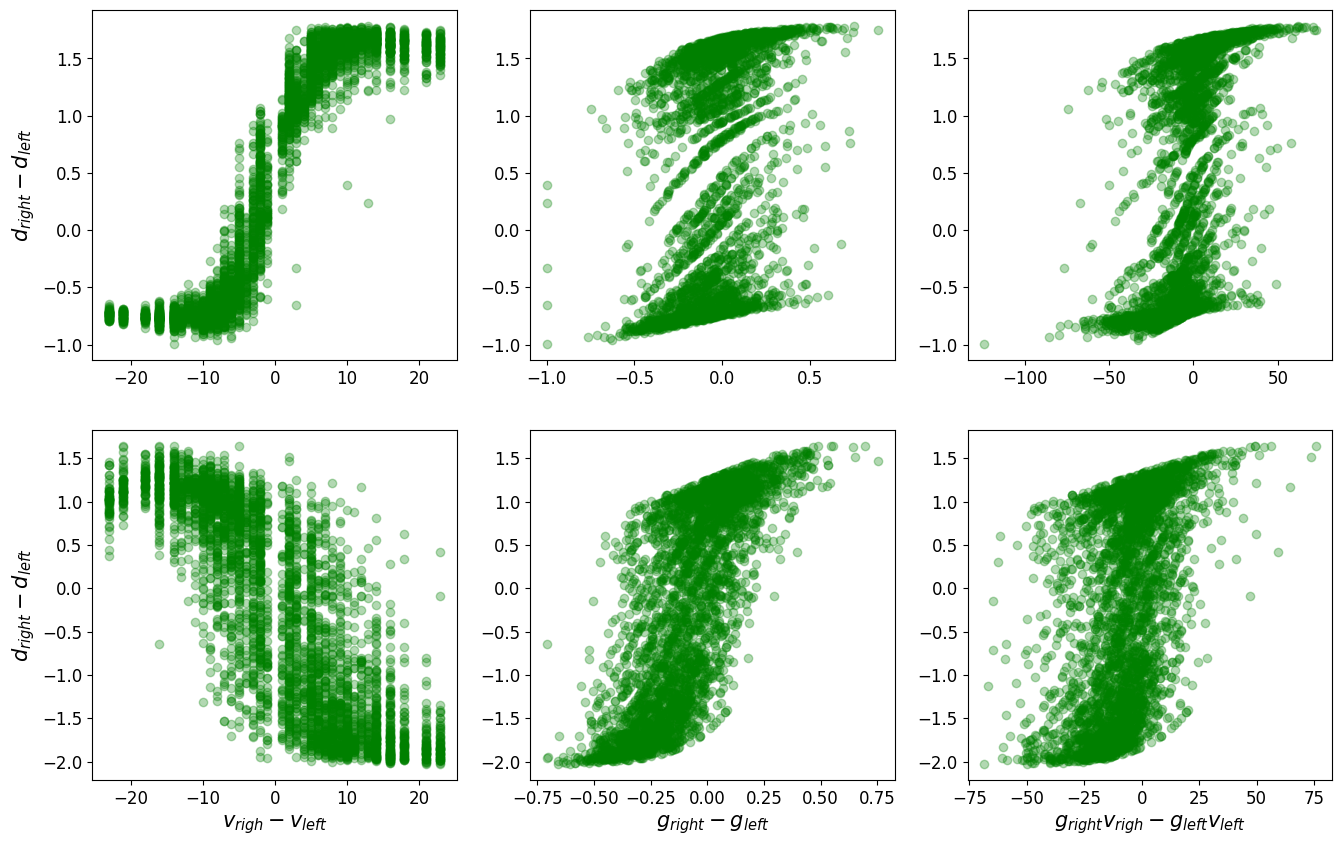

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');